# An AI-Driven Approach to Adapting the Expected Goals (xG) Model to Women’s Football

The **Expected Goals (xG)** model is a key metric in football analytics, yet conventional models overlook biomechanical and tactical differences in women’s football. This study introduces an AI-driven xG model, integrating novel contextual variables like Defensive Congestion Index (DCI) and Shot Block (SB). Using neural networks, the model improves predictive accuracy over traditional approaches. Results show distinct shot conversion patterns in women’s football, particularly for long-range attempts, underscoring the need for gender-specific modeling. Incorporating additional features reduces log loss and enhances shot predictions.

The data comes from **Hudl StatsBomb Open Data**.

In [1]:
import pandas as pd
import warnings
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss
import ast
from matplotlib.patches import Polygon as mpl_Polygon
from matplotlib.patches import Wedge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from collections import defaultdict

warnings.filterwarnings('ignore')

---
**Configuration**

To ensure the stability of the network, it can be run multiple times, although this comes with increased computational complexity.
Here you can choose whether to run the neural network once or multiple times. If you want to run it once, leave the value set to **True**; if you want to run it 10 times, you should change it to **False**.

---

In [2]:
# Choose True or False
single_network_run = False

### Data Used for the Analysis

The file equal_datagrame.csv was generated from the data_preparation script.

The analysis uses all available women's data and the equivalent amount of men's data from the following competitions and seasons:

- Men's World Cup 2022
- Men's World Cup 2018
- Women's World Cup 2023
- Women's World Cup 2019
- Women's European Championship 2023
- La Liga 2015/16
- National Women's Soccer League
- Super League 2020/21
- Super League 2019/20
- Super League 2018/19

The datasets cover both men's and women's major international tournaments as well as top-level domestic leagues. This variety allows for an assessment of xG consistency across gender and different league contexts.

In [3]:
# Reads csv file and creates gender dataframes
df = pd.read_csv('equal_dataframe.csv')

df_women = df[df['gender'] == 'female']
df_men = df[df['gender'] == 'male']

---

### Distribution of Final Match xG by Gender

Let's start by examining the distribution of final match xG for both genders.

---

In [4]:
# Calculates the cumulative xG for each gender
df_women['cumulative_xg'] = df_women.groupby(['match_id', 'team_id'])['shot_statsbomb_xg'].cumsum()
df_men['cumulative_xg'] = df_men.groupby(['match_id', 'team_id'])['shot_statsbomb_xg'].cumsum()

In [5]:
# Creates xG flow charts

def create_xg_flow_chart(df, ax, title):

    home_team_id = df['team_id'].unique()[0]

    home_color = 'darkred'
    away_color = 'royalblue'
    
    # Plots the xG for each team by half
    for team in df['team_id'].unique():
        
        team_df = df[df['team_id'] == team]
        
        # add a 0 xG row at the start of the match
        team_df = pd.concat([pd.DataFrame({
            'team_id': team, 'minute': 0, 'shot_statsbomb_xg': 0, 'shot_outcome': None, 'cumulative_xG': 0, 'period': 1
        }, index=[0]), team_df])
        
        ax.plot(
            team_df['minute'], 
            team_df['cumulative_xg'], 
            label = team, 
            drawstyle = 'steps-post',
            c = home_color if team == home_team_id else away_color
        )   
            
    
    # Adds a scatter plots to show the goals
    for team in df['team_id'].unique():
        
        team_df = df[(df['team_id'] == team) & (df['shot_outcome'] == 'Goal')].to_dict(orient = 'records')
        
        for x in team_df:

            # Adds circles for goals
            ax.scatter(
                x['minute'], 
                x['cumulative_xg'], 
                c = home_color if team == home_team_id else away_color,
                edgecolor = home_color if team == home_team_id else away_color,
                s = 60,
                zorder = 5
            )
            
            # Adds labels for goal scorers
            ax.text(
                x['minute'], 
                x['cumulative_xg'] - 0.07, 
                x['player'], 
                ha = 'center', 
                va = 'center', 
                fontfamily = 'monospace', 
                fontsize = 8,
                zorder = 10
            )

    ax.set_title(title)
    
    # Labels the x axis with first and second half
    ax.set_xticks([0, 45, 90, 120])
    ax.set_xticklabels(['0\'', '45\'', '90\'', '120\''])
    
    # Gets rid of the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

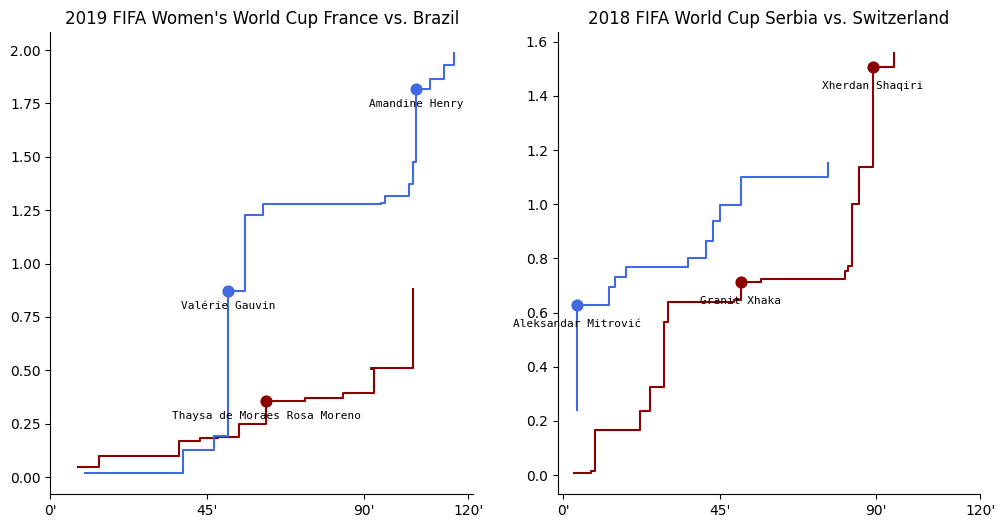

In [6]:
# A visual representation of cumulative xG along with goal scorers.

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
create_xg_flow_chart(df_women[df_women['match_id'] == 69137], axes[0], "2019 FIFA Women's World Cup France vs. Brazil")
create_xg_flow_chart(df_men[df_men['match_id'] == 7550], axes[1], "2018 FIFA World Cup Serbia vs. Switzerland")

In [7]:
# Finds the final xG in the match

cumulative_xG_for_women = (
    df_women.groupby(['match_id', 'team_id'], as_index=False)
      .last()['cumulative_xg']
)
cumulative_xG_for_men = (
    df_men.groupby(['match_id', 'team_id'], as_index=False)
      .last()['cumulative_xg']
)

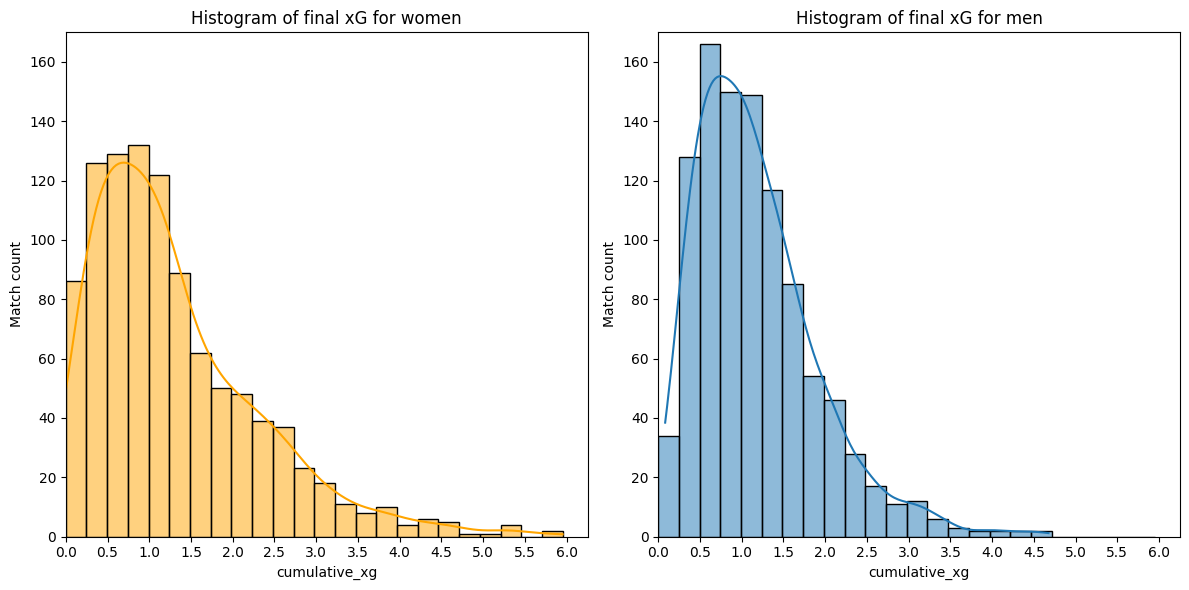

In [8]:
# Plots histograms with final xG

max_x = max(max(cumulative_xG_for_women), max(cumulative_xG_for_men))

x_ticks = np.arange(0, max_x + 0.5, 0.5)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(cumulative_xG_for_women, kde=True, binwidth=0.25, binrange=(0, max_x), ax=axes[0], color='orange')
axes[0].set_title("Histogram of final xG for women")
axes[0].set_xlim(left=0)
axes[0].set_ylim(0, 170)
axes[0].set_xticks(x_ticks)
axes[0].set_ylabel("Match count")

sns.histplot(cumulative_xG_for_men, kde=True, binwidth=0.25, binrange=(0, max_x), ax=axes[1])
axes[1].set_title("Histogram of final xG for men")
axes[1].set_xlim(left=0)
axes[1].set_ylim(0, 170)
axes[1].set_xticks(x_ticks)
axes[1].set_ylabel("Match count")

plt.tight_layout()
plt.show()

---
### Conclusion

As shown in the charts, the xG distributions for each gender differ slightly. Women more frequently have matches with either very low or very high xG values, while men usually do not reach such extreme results.

---

## Key Finding: Gender Difference in Long-Distance Shots

An interesting, non-obvious aspect of the game that differs between men's and women's football has been identified in recent research.  
A potential candidate was long-distance shots, given their specific nature — requiring significant power.  
This turned out to be a perfect choice, as this aspect indeed shows a notable difference between genders.

---

### Long-range shot visualization

---

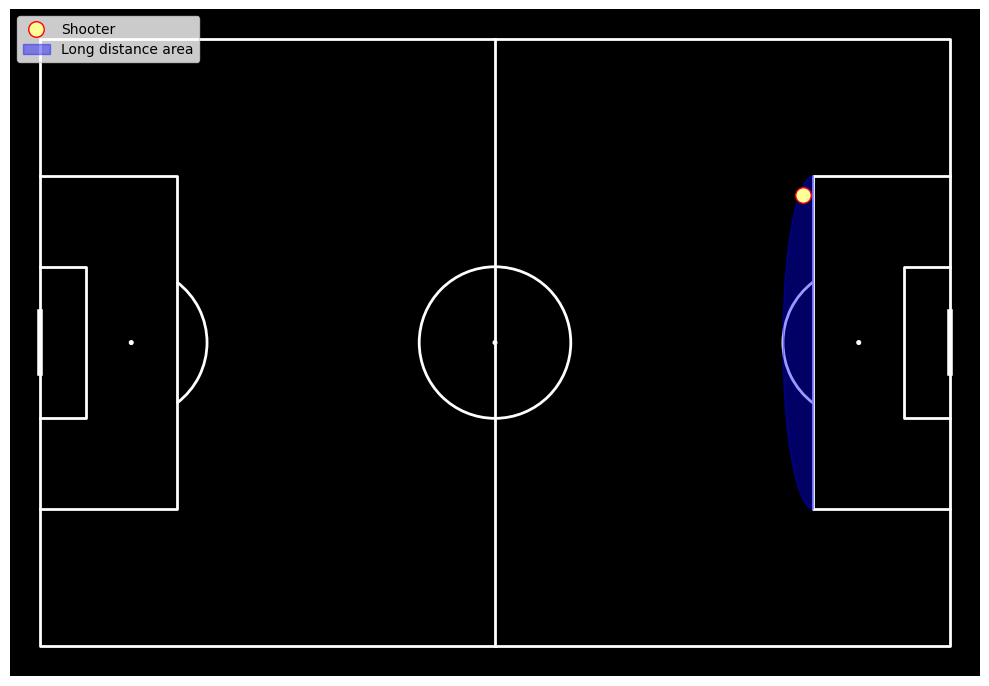

In [9]:
# Displays long distance area in the style of StatsBomb

df_shot_freeze_frame = df[df['match_id'] == 69137].iloc[13:14]

pitch = Pitch(pitch_type='statsbomb', line_color='white', pitch_color='black')
fig, ax = pitch.draw(figsize=(10, 7))

shooter_x = df_shot_freeze_frame['x'].iloc[0]
shooter_y = df_shot_freeze_frame['y'].iloc[0]

# Shooter
ax.scatter(
    shooter_x, 
    shooter_y, 
    color='#ffff99', edgecolor='red', s=125, zorder=3, label='Shooter'
)

# Long distance area
theta = np.linspace(90, -90, 50)  
arc_x = 4 * np.cos(np.radians(theta)) + 102
arc_y = 22 * np.sin(np.radians(theta)) + 40
ax.fill(204 - arc_x, arc_y, 40, color='blue', alpha=0.4, label='Long distance area')

# Legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.show()

The shot presented in the visualization above is **not** classified as a long-distance shot.  
Only attempts taken from outside the blue zone and the penalty area are considered long-distance shots in this context.

---

### Long-range shot analysis

---

In [10]:
# Binary defines a longshot

outside_penalty_area = (df['x'] < 102) | (df['y'] < 18) | (df['y'] > 62)
outside_long_distance_area = ((df['x'] - 102) / 4) ** 2 + ((df['y'] - 40) / 22) ** 2 >= 1

df['longshot'] = outside_penalty_area & outside_long_distance_area

In [12]:
# Shows longshot statistics

# Adds a binary column: goal = 1 (goal), goal = 0 (no goal)
df['goal'] = df['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)

longshot_counts = df[df['longshot'] == True].groupby('gender')['goal'].count()
longshot_goals = df[(df['longshot'] == True) & (df['goal'] == 1)].groupby('gender')['goal'].count()
total_shots = df.groupby('gender')['goal'].count()

result = pd.DataFrame({
    'longshot_counts': longshot_counts,
    'longshot_goals': longshot_goals,
    'longshot_goals / longshot_counts': longshot_goals / longshot_counts,
    'longshot_counts / total_shots': longshot_counts / total_shots,
    'longshot_goals / total_shots': longshot_goals / total_shots
})

for gender, row in result.iterrows():
    print(f"Gender: {gender}")
    print(f"Long-range shots: {int(row['longshot_counts'])}")
    print(f"Long-range goals: {int(row['longshot_goals'])}")
    print(f"Long-range accuracy: {row['longshot_goals / longshot_counts']:.2%}")
    print(f"Long-range frequency: {row['longshot_counts / total_shots']:.2%}")
    print(f"Long-range goals/all: {row['longshot_goals / total_shots']:.2%}")
    print("-" * 50)

Gender: female
Long-range shots: 3507
Long-range goals: 129
Long-range accuracy: 3.68%
Long-range frequency: 26.90%
Long-range goals/all: 0.99%
--------------------------------------------------
Gender: male
Long-range shots: 3554
Long-range goals: 87
Long-range accuracy: 2.45%
Long-range frequency: 29.28%
Long-range goals/all: 0.72%
--------------------------------------------------


As can be seen from the above analysis, quite unexpectedly, women achieve better results in long-distance shots.  
With this knowledge in mind, five new parameters have been created to improve the model's prediction performance.  
These attributes are:

1. **SB (Shot Block):**
   - `players_in_shot_keeper_cone`  
   - `opponent_players_in_shot_keeper_cone`  
   - `goalkeeper_in_shot_keeper_cone`  

2. **DCI (Defensive Congestion Index):**
   - `players_in_the_box`  
   - `pressing`  

### Parameters visualization

---

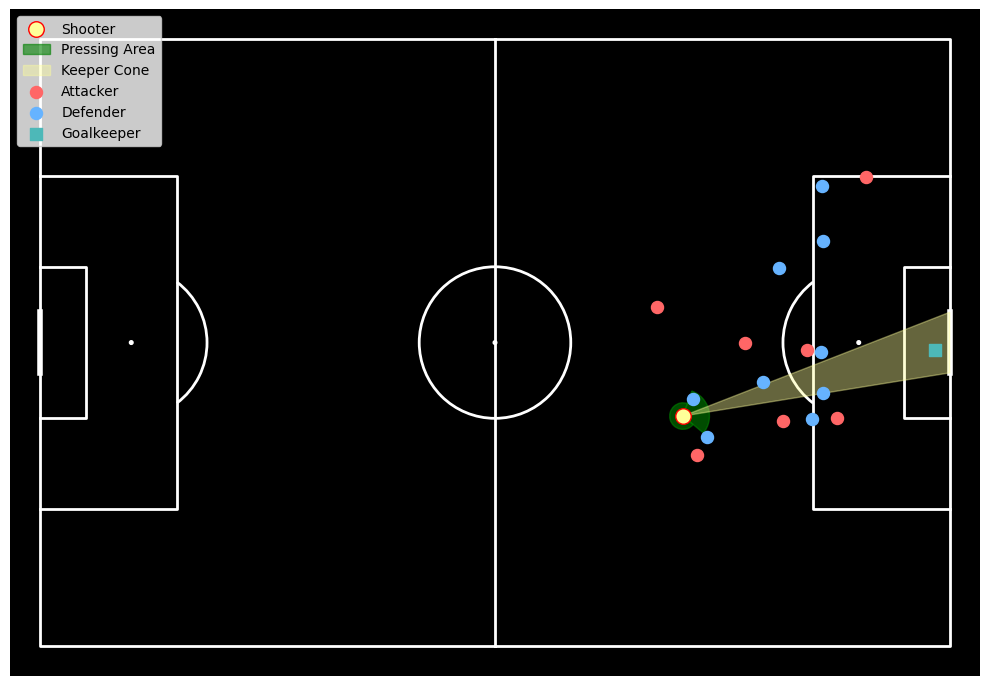

In [13]:
# Displays the map of players, keeper cone, and pressing areas in the style of StatsBomb

df_shot_freeze_frame = df[df['match_id'] == 69137].iloc[17:18]

pitch = Pitch(pitch_type='statsbomb', line_color='white', pitch_color='black')
fig, ax = pitch.draw(figsize=(10, 7))

shooter_x = df_shot_freeze_frame['x'].iloc[0]
shooter_y = df_shot_freeze_frame['y'].iloc[0]

# Shooter
ax.scatter(
    shooter_x, 
    shooter_y, 
    color='#ffff99', edgecolor='red', s=125, zorder=3, label='Shooter'
)

# Goal coordinates
goal_center_x = 120
goal_center_y = 40
goal_top_y, goal_bottom_y = 44, 36

angle = np.arctan2(goal_center_y - shooter_y, goal_center_x - shooter_x) * 180 / np.pi

# Pressing areas
shooter_in_front_area = Wedge(
    (shooter_x, shooter_y),
    r=3.5,
    theta1=angle - 55,
    theta2=angle + 55,
    color='green',
    alpha=0.6,
    label='Pressing Area'
)
ax.add_patch(shooter_in_front_area)

behind_shooter_area = Wedge(
    (shooter_x, shooter_y),
    r=1.75,
    theta1=angle + 55,
    theta2=angle - 55,
    color='green',
    alpha=0.6
)
ax.add_patch(behind_shooter_area)

# Keeper cone
keeper_cone_points = [
    (shooter_x, shooter_y),
    (goal_center_x, goal_top_y),
    (goal_center_x, goal_bottom_y)
]

keeper_cone = mpl_Polygon(keeper_cone_points, closed=True, color='#ffff99', alpha=0.4, zorder=1, label='Keeper Cone')
ax.add_patch(keeper_cone)

# Parses freeze_frame to list
freeze_frame = ast.literal_eval(df_shot_freeze_frame['shot_freeze_frame'].iloc[0])

goalkeeper = next((player for player in freeze_frame if not player['teammate'] and player.get('position_name') == 'Goalkeeper'), None)

# Displays players
for player in freeze_frame:
    
    loc = player['location']
    
    if player == goalkeeper:
        
        ax.scatter(loc[0], loc[1], color='#4db8b8', s=75, zorder=2, marker='s', label='Goalkeeper')
        
    elif player['teammate']:
        
        ax.scatter(loc[0], loc[1], color='#ff6666', s=75, zorder=2, label='Attacker')
        
    else:
        
        ax.scatter(loc[0], loc[1], color='#66b3ff', s=75, zorder=2, label='Defender')

# Legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.show()

---

### my xG model

New xG model named *my xG* is created.

---

In [14]:
# Calculates my xG

def calculate_my_xG_with_nn(df):

    # Attributes - 14
    features = [
        'angle_degrees', 'distance', 
        'gender', 'goalkeeper_in_shot_keeper_cone',
        'opponent_players_in_shot_keeper_cone',
        'play_pattern', 'players_in_shot_keeper_cone',
        'players_in_the_box', 'pressing', 'shot_aerial_won', 
        'shot_body_part', 'shot_technique',
        'shot_type', 'under_pressure'
    ]

    # Log loss calculations for avg and StatsBomb xG
    mean_goal_probability = df['goal'].mean()
    average_log_loss = log_loss(df['goal'], [mean_goal_probability] * len(df))
    statsbomb_xg_log_loss = log_loss(df['goal'], df['shot_statsbomb_xg'])
    
    print(f"Log Loss for average probability: {average_log_loss:.3f}")
    print(f"Log Loss for StatsBomb xG: {statsbomb_xg_log_loss:.3f}")

    def run_single_network(df):
        
        # Dependent variable
        y = df['goal']
        
        # One-hot encoding for categorical variables
        X = pd.get_dummies(df[features], drop_first=True)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Define neural network model
        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
    ])
    
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
        early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
        model.fit(X_train_scaled, y_train, 
                  validation_data=(X_test_scaled, y_test), 
                  epochs=50, 
                  batch_size=16, 
                  callbacks=[early_stopping], 
                  verbose=0)

        y_test_pred = model.predict(X_test_scaled, verbose=0).flatten()
        my_xg_log_loss = log_loss(y_test, y_test_pred)
    
        # Calculates features importance
        def compute_permutation_importance_keras(model, X_scaled, y_true, columns):
            
            baseline_loss = log_loss(y_true, model.predict(X_scaled, verbose=0).flatten())
            importances = {}
        
            for i, col in enumerate(columns):
                X_permuted = X_scaled.copy()
                X_permuted[:, i] = np.random.permutation(X_permuted[:, i])
                y_pred = model.predict(X_permuted, verbose=0).flatten()
                loss = log_loss(y_true, y_pred)
                importances[col] = loss - baseline_loss
    
            importance_series = pd.Series(importances)
            importance_percent = 100 * importance_series / importance_series.sum()
            
            return importance_percent.sort_values(ascending=False).round(2)
            
        X_full_scaled = scaler.transform(X)
        my_xg = model.predict(X_full_scaled, verbose=0).flatten()

        feature_importance = compute_permutation_importance_keras(model, X_test_scaled, y_test, X.columns)

        return my_xg_log_loss, feature_importance, my_xg

    if single_network_run:
        
        logloss, feature_importance, my_xg = run_single_network(df)
        df['my_xg'] = my_xg

        print(f"Log Loss for my_xG (NN): {logloss:.3f}")
        print("\nFeature importance (%):\n")
        print(feature_importance.head(10))

    # Repeated neural network training (10 runs)
    else:
        
        log_losses = []
        all_importances = []
        all_my_xgs = []

        for _ in range(10):
            
            logloss, feature_importance, my_xg = run_single_network(df)
            log_losses.append(logloss)
            all_importances.append(feature_importance)
            all_my_xgs.append(my_xg)

        # Avg and std log loss
        avg_logloss = np.mean(log_losses)
        std_logloss = np.std(log_losses)

        # Avg my_xG for every shot
        df['my_xg'] = np.mean(all_my_xgs, axis=0)

        # Avg and std for features importance
        all_importances_df = pd.concat(all_importances, axis=1)
        mean_importance = all_importances_df.mean(axis=1)
        std_importance = all_importances_df.std(axis=1)
        
        importance_summary = pd.DataFrame({
            'mean_importance': mean_importance.round(2),
            'std_importance': std_importance.round(2)
        }).sort_values(by='mean_importance', ascending=False)

        print(f"Log Loss for my_xG (NN) - avg: {avg_logloss:.3f}, std: {std_logloss:.3f}")
        print("\nFeature importance (%):\n")
        print(importance_summary.head(10))

In [15]:
# Plots comparison of xG value distributions

def comparison_my_xG(df):
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].set_facecolor('lightgray')
    ax[1].set_facecolor('lightgray')
    
    ax[0].hist(df['my_xg'], bins=30, alpha=0.7, label="my xG", edgecolor='black', color='skyblue')
    ax[0].set_xlabel("xG", fontsize=12)
    ax[0].set_ylabel("Number of Shots", fontsize=12)
    ax[0].legend()
    ax[0].grid(True, linestyle='--', alpha=0.6)
    ax[0].set_xlim(left=0)
    ax[0].set_ylim(0, 10000)
    
    ax[1].hist(df['shot_statsbomb_xg'], bins=30, alpha=0.7, color='#e63946', label="StatsBomb xG", edgecolor='black')
    ax[1].set_xlabel("xG", fontsize=12)
    ax[1].legend()
    ax[1].grid(True, linestyle='--', alpha=0.6)
    ax[1].set_xlim(left=0)
    ax[1].set_ylim(0, 10000)
    
    plt.suptitle("Comparison of xG Value Distributions Gender-equal data", fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 1])
    
    plt.show()

In [16]:
# Calculates log losses and displays features importance
calculate_my_xG_with_nn(df)

Log Loss for average probability: 0.330
Log Loss for StatsBomb xG: 0.265
Log Loss for my_xG (NN) - avg: 0.259, std: 0.001

Feature importance (%):

                                      mean_importance  std_importance
angle_degrees                                   32.52            3.03
distance                                        27.92            2.00
shot_body_part_Right Foot                       12.14            1.65
shot_body_part_Left Foot                         8.43            1.40
players_in_the_box                               3.20            1.00
shot_technique_Lob                               3.15            0.73
pressing                                         2.75            0.77
players_in_shot_keeper_cone                      2.39            0.64
shot_type_Open Play                              1.57            0.93
opponent_players_in_shot_keeper_cone             1.20            0.69


---
### Results

As shown, most of the newly created features are among the top contributors in terms of model importance. The model also exhibits a very low log loss, indicating strong predictive performance.

---

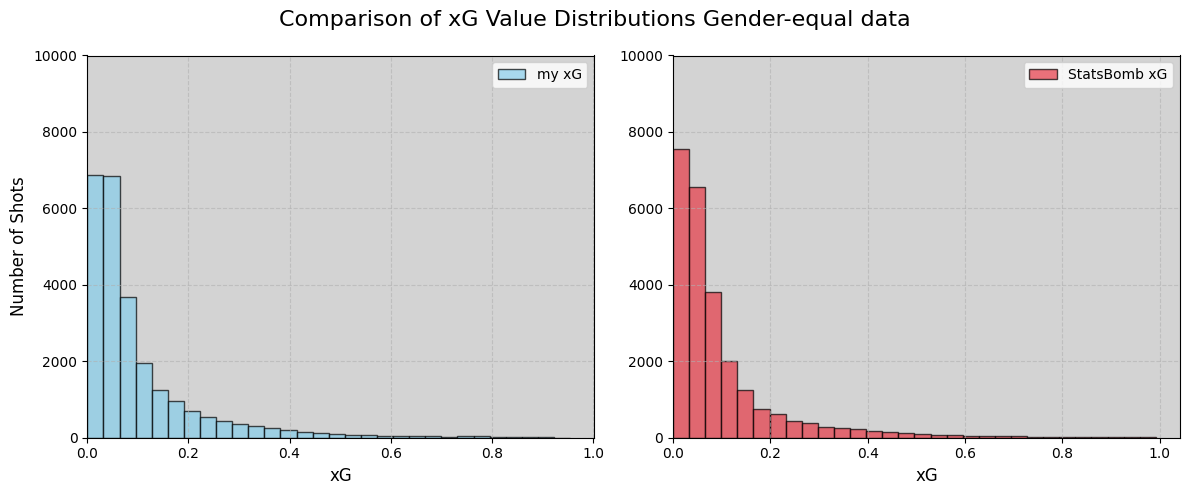

In [17]:
# Shows histograms of xG distributions
comparison_my_xG(df)

## 🧠 **1. Explanation**

One key motivation behind this project was the observation that female players tend to score more frequently from long-distance shots. This phenomenon is likely linked to the fact that goalkeepers in women’s football are significantly shorter than their male counterparts, yet they play on goals of the same dimensions. As a result, shots from outside the box pose a relatively higher threat, offering a unique angle for tactical and statistical analysis.


## 🎯 **2. Topic Selection**

Throughout the project, I conducted numerous analyses across various aspects of the game. In collaboration with my supervisor, we selected this particular topic due to its high research potential and the fact that **women’s football is developing rapidly**, both on and off the pitch.

---

## 📊 **3. Key Findings**

The analysis revealed a **notable distinction between women’s and men’s football** — specifically, the prevalence and characteristics of **long-range goals** in the women’s game. This finding reinforces the need for a dedicated women’s xG model that is more sensitive to long-range shot patterns.

The study provided a deeper understanding of the women’s football context. The custom model, **my xG**, after incorporating additional variables (_SB + DCI_), **reduced the log loss from 0.273 to 0.259**. Importantly, **most newly added features ranked among the most influential variables** in the model.

---

## 🧩 **4. Research Presentation**

The project was presented both as a **poster and oral presentation** at the _6th Polish Conference on Artificial Intelligence_. The implementation was part of the **IDUB research project No. 134**. The project was also described in my master's thesis.

---

## 🚀 **5. Future Work**

The project will be further developed in the future, particularly with the **emergence of new datasets for women’s football**, allowing for more stable and robust modeling. 

An exciting direction for future work would be to **parameterize the pressing area** in such a way that **AI could learn and optimize its shape and coverage based on match data**.